# Dengue Analysis for Municipalities

## 0. Imports

### 0.1. Libraries

In [1]:
# Data manipulation libraries
import pandas                as pd
import numpy                 as np

# Visualization libraries
import seaborn               as sns
import matplotlib            as mpl
import matplotlib.pyplot     as plt

from matplotlib              import cm
from matplotlib.colors       import Normalize

from mpl_toolkits.axes_grid1 import make_axes_locatable

# import plotly.express       as px
# import plotly.graph_objects as go

# Geo libraries
import geopandas             as gpd

# Other
import warnings
import sys
import os

### 0.2. Settings

In [2]:
# Ignoring warnings
warnings.filterwarnings('ignore')

# Pandas Settings
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)

# Directory Settings
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))
src_path     = os.path.join(project_root, 'src')
sys.path.append(src_path)

# Visualization Settings
%matplotlib inline

# Set a style
mpl.style.use('ggplot')  

# Customize rcParams
mpl.rcParams.update({
    'axes.titlesize': 20,
    'axes.labelsize': 12,
    'axes.facecolor': 'white',
    'axes.linewidth': 1,
    'axes.grid': True,
    'xtick.labelsize': 12,
    'xtick.bottom': False,
    'ytick.labelsize': 12,
    'ytick.left': False,
    'legend.fontsize': 12,
    'lines.linewidth': 2,
    'lines.markersize': 6,
    'grid.color': 'lightgray',
    'grid.linestyle': '-',
    'grid.linewidth': 0.5,
    'font.size': 12,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'figure.titlesize': 24,
    'figure.figsize': (18, 9),
    'figure.dpi': 150
})

### 0.3. Functions

In [3]:
def set_plot(fig, title, xlabel, ylabel):
    """
    Summary: This function sets the plot configuration for the initial plots. 
    Args:
        fig: the figure object.
        title: the title of the plot.
        xlabel: the label for the x axis.
        ylabel: the label for the y axis.
    Returns: figure with the image configuration.
    """
    # Customizing
    fig.set_title(title)
    fig.set_xlabel(xlabel, color='black')
    fig.set_ylabel(ylabel, color='black')

    return fig

def plot_taxa_incidencia_media(gdf, df_txinc, intervals, title, cmap='cividis', wspace=-0.25, hspace=None):
    """
    Summary: This function plots the mean incidence rate for each interval.
    Args:
        gdf: GeoDataFrame with the municipalities.
        df_txinc: DataFrame with the mean incidence rate by municipality and year.
        intervals: List of tuples with the years for the intervals.
        title: The title of the plot.
        cmap: The colormap for the choropleth map.
        wspace: The width space between subplots.
        hspace: The height space between subplots.
    Returns: figure with the image configuration.
    """

    aux_list = []
    for interval in intervals:
        aux = gdf.merge(
            df_txinc[df_txinc['ano'].isin(interval)].groupby(['id_mun'])['txinc'].mean().reset_index(), 
            on='id_mun'
        )
        aux_list.append(aux)
    
    # Plotting
    fig, axes = plt.subplots(2, 2)

    for i, ax in enumerate(axes.flat):
        aux_list[i].plot(ax=ax, column='txinc', cmap=cmap, legend=True)
        ax.set_title(f'{intervals[i][0]}-{intervals[i][-1]}')
    
    # Main title and spacing adjustments
    fig.suptitle(title)
    fig.subplots_adjust(wspace=wspace, hspace=hspace)
    
    plt.show()

### 0.4. Classes

### 0.5. Datasets

In [4]:
# Casos
df_casos = pd.read_csv('../data/interim/mun_dengue_casos_amazonia_legal.csv')

# Óbitos
df_obitos = pd.read_csv('../data/interim/mun_dengue_obitos_amazonia_legal.csv')

In [5]:
# População
df_pop = pd.read_csv('../data/interim/mun_populacao.csv')

In [6]:
# GeoDataFrame MU Brasil
gdf = gpd.read_file('../data/interim/amazonia_legal.geojson')

In [7]:
# Amazônia Legal Brasileira
alb = pd.read_csv('../data/interim/mun_amazonia_legal.csv')

## 1. Data Preparation

### Listas Auxiliares

In [8]:
# Lista de municípios da ALB
lista_mun_alb = alb.cod_ibge.to_list()

### Ajustando População

In [9]:
# Filtrando os dados
df_pop = df_pop[df_pop['cod_ibge'].isin(lista_mun_alb)]

# Ajustando os anos
df_pop['2023'] = df_pop['2022']

# Dropping 
df_pop.drop(columns=['nome_municipio', 'sigla_UF'], inplace=True)

# Melt
df_pop = pd.melt(df_pop, id_vars=['cod_ibge', 'id_mun'], var_name='ano', value_name='pop')

# Changing types
df_pop = df_pop.astype('int64')

### Taxa de Incidência

In [10]:
# Calculando taxa de incidência
df_txinc = pd.merge(df_pop, df_casos, on=['cod_ibge', 'id_mun', 'ano'], how='left')

# Corrigindo para municípios com anos faltantes que agora têm valor NaN
df_txinc = df_txinc.fillna(0)
df_txinc['casos'] = df_txinc['casos'].astype('int64')

# Casos / População * 100,000 habitantes
df_txinc['txinc'] = df_txinc['casos'] / df_txinc['pop'] * 100000

# Filtrando
df_txinc = df_txinc[['cod_ibge', 'id_mun', 'ano', 'txinc']]

# Corrigindo para municípios que não existiam 
df_txinc = df_txinc.fillna(0)

### Taxa de Mortalidade

### Taxa de Letalidade

## 2. Data Exploration

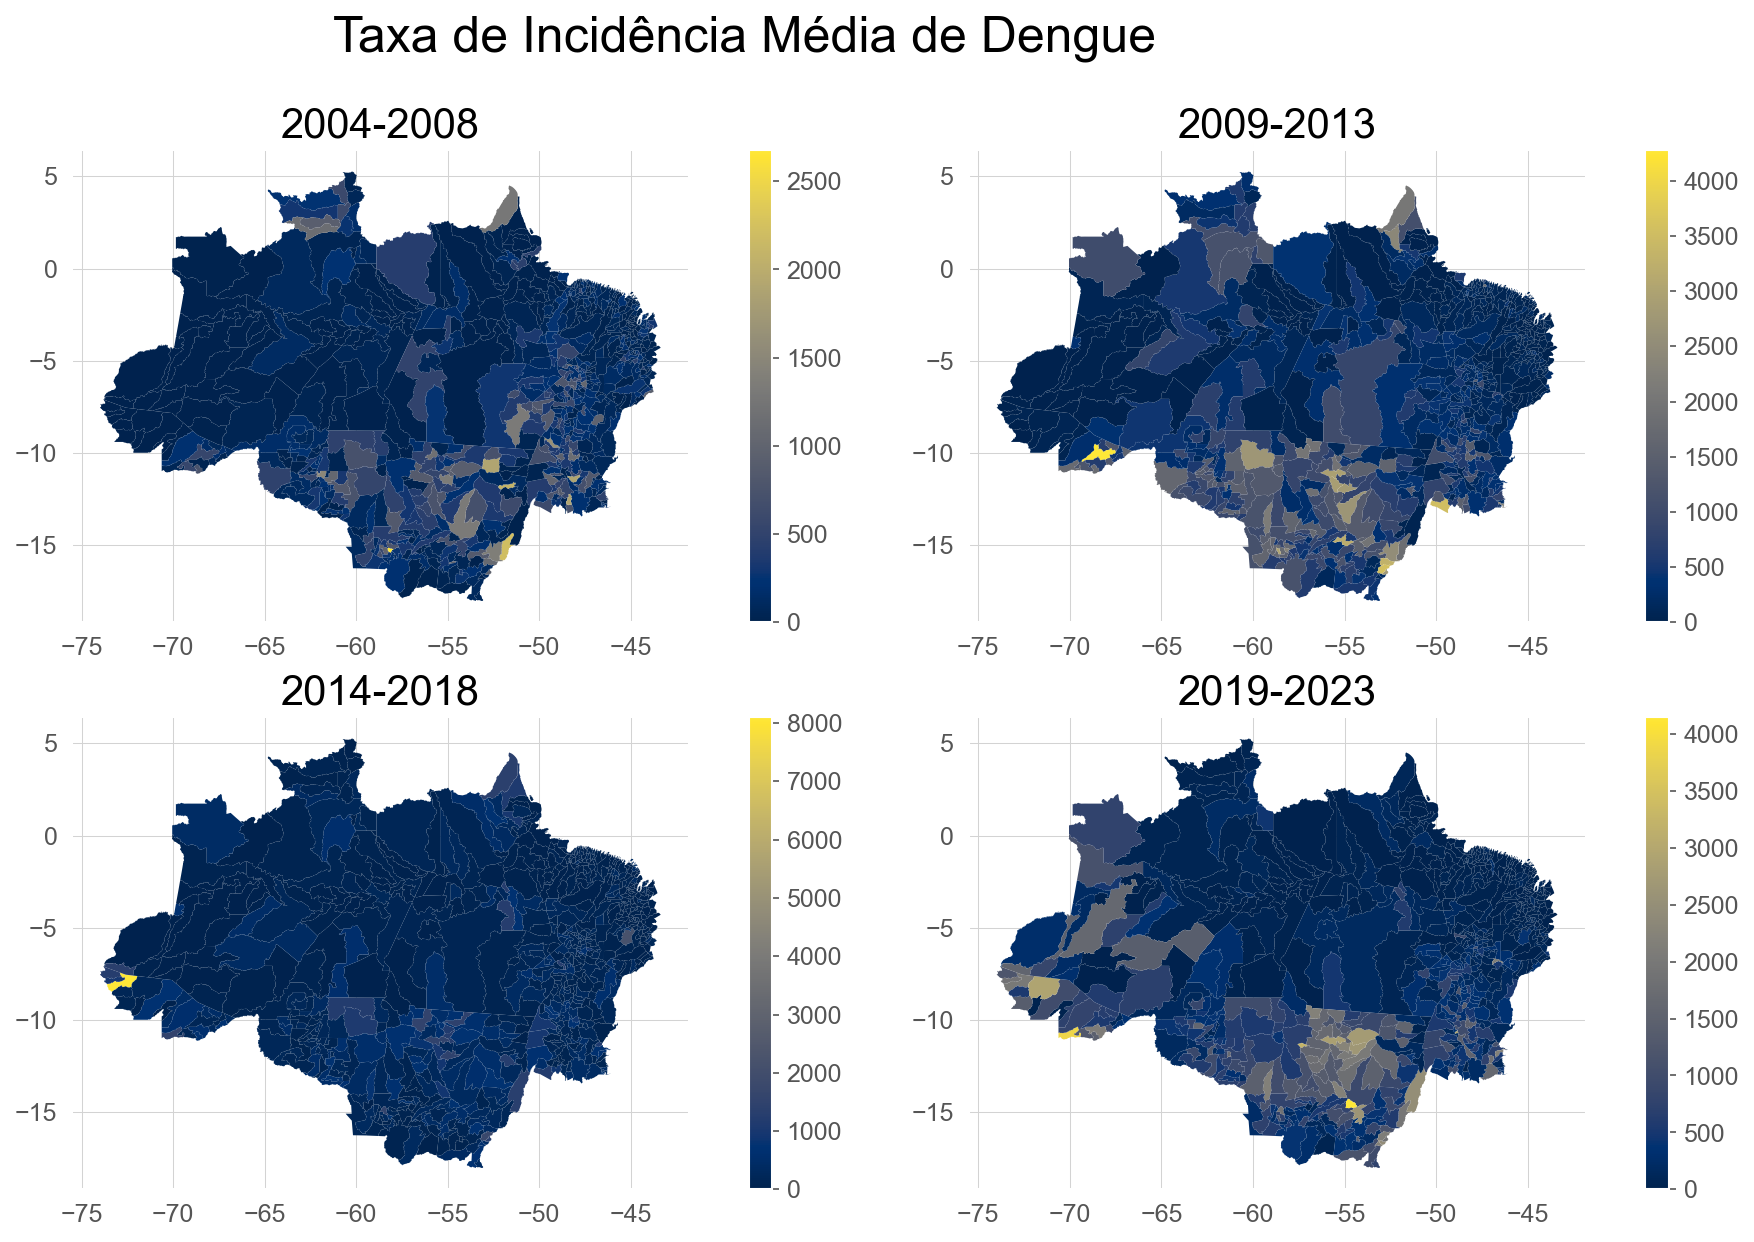

In [13]:
# Taxa de Incidência
intervals = [
    [2004, 2005, 2006, 2007, 2008],
    [2009, 2010, 2011, 2012, 2013],
    [2014, 2015, 2016, 2017, 2018],
    [2019, 2020, 2021, 2022, 2023]
]

plot_taxa_incidencia_media(
    gdf = gdf,
    df_txinc = df_txinc,
    intervals = intervals,
    title = 'Taxa de Incidência Média de Dengue'
)

## 3. Data Statistics